In [1]:
using MGVInference

┌ Info: Precompiling MGVInference [adafd34d-b6c4-4402-9c42-0a5fd7754124]
└ @ Base loading.jl:1278


In [61]:
fft_gp_model = "../test/test_models/fft_gp.jl"
open(fft_gp_model, "r") do io
    map(println, readlines(io))
end
include(fft_gp_model)

# This file is a part of MGVInference.jl, licensed under the MIT License (MIT).

import Base: *, adjoint
import AbstractFFTs
import FFTW: plan_r2r, DHT
import ForwardDiff
import Random: randn, MersenneTwister
import Distributions: MvNormal
import ValueShapes: NamedTupleDist
import Zygote
import LinearAlgebra: Diagonal

_dims = 40
_k = [i < _dims / 2 ? i : _dims-i for i = 0:_dims-1]

# Define the harmonic transform operator as a matrix-like object
_ht = plan_r2r(zeros(_dims), DHT)

# Unfortunately neither Zygote nor ForwardDiff support planned Hartley
# transformations. While Zygote does not support AbstractFFTs.ScaledPlan,
# ForwardDiff does not overload the appropriate methods from AbstractFFTs.
function _plan_dual_product(trafo::AbstractFFTs.Plan, u::Vector{ForwardDiff.Dual{T, V, N}}) where {T, V, N}
    # Unpack AoS -> SoA
    vs = ForwardDiff.value.(u)
    ps = mapreduce(ForwardDiff.partials, hcat, u)
    # Actual computation
    val = trafo * vs
    jvp = [trafo*t[:] for t in each

40-element Array{Float64,1}:
 -0.2182971373018973
 -1.7218447499307976
  0.603715678803879
 -0.21179751899630508
 -0.44777338300787084
 -0.4476889572053994
  2.013315941253755
  0.7635310957132931
 -0.0981351745482496
  0.14246898420247958
 -2.893510412007984
  0.271258492099812
  0.49524834448070404
  ⋮
  1.7356116899036684
  1.8546456957399085
  0.2265671769535978
  0.2545780573368525
 -0.1958819956230198
 -0.3239403481351395
  0.21917922464094056
 -0.3926885430284329
 -0.31484314959998216
  2.2659326905628294
 -0.289867554971233
  1.0991094524324592

In [62]:
using Distributions
using Random
using ValueShapes
using LinearAlgebra
using Plots

In [63]:
data = rand(model(true_params), 1)[1];

In [64]:
_common_grid = [1:_dims...];

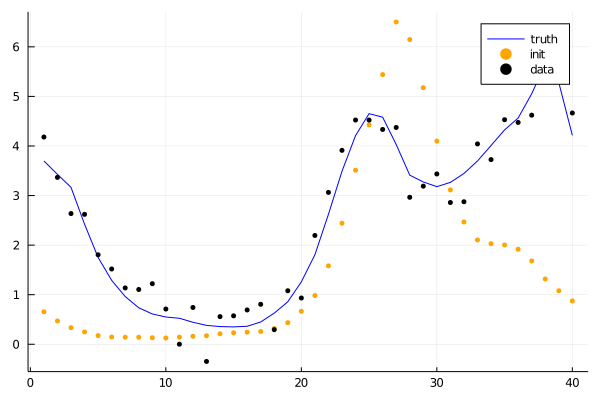

In [65]:
init_plots =() -> let
    truth = _mean(true_params)
    plot!(_common_grid, truth, markercolor=:blue, linecolor=:blue, label="truth")
    scatter!(_common_grid, _mean(starting_point), markercolor=:orange, markerstrokewidth=0, markersize=3, label="init")
    scatter!(_common_grid, MGVInference.unshaped(data), markercolor=:black, markerstrokewidth=0, markersize=3, label="data")
end
plot()
init_plots()

In [66]:
first_iteration = mgvi_kl_optimize_step(model, data, starting_point; jacobian_func=FwdDerJacobianFunc, residual_sampler=FullResidualSampler)

display(hcat(first_iteration, true_params))

40×2 Array{Float64,2}:
  0.471117      0.48151
 -0.609094     -0.564916
  1.69947       1.63042
 -1.23615      -1.14073
  0.132659      0.867529
 -0.314548      0.0598623
 -0.126494     -1.64938
 -0.522714     -0.552528
 -0.28237      -0.472529
 -0.252865     -0.468033
  0.170104     -0.200177
  0.281782     -0.944585
  0.0195459     0.75603
  ⋮            
  0.00197171   -0.268811
  0.057758      0.0891861
 -0.326625     -2.73701
 -0.223564     -1.57267
 -0.187897     -0.859427
  0.000234162  -0.795277
 -0.0461342    -0.75824
  0.675058     -0.572864
 -0.378402     -0.559156
  0.633352      0.841274
  0.443436      0.298653
  1.21325       1.25313

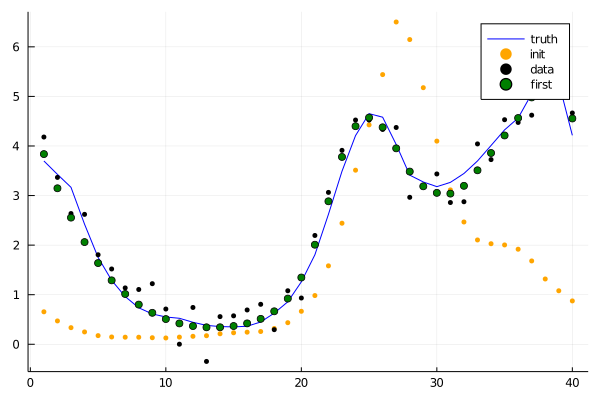

In [67]:
plot_iteration = (params, label) -> let
    #error_mat = mgvi_kl_errors(full_model, params)
    #display(error_mat)
    #errors = sqrt.(error_mat[diagind(error_mat)])
    #yerr = abs.(line(common_grid, params+errors) - line(common_grid, params-errors))
    #scatter!(common_grid, line(common_grid, params), markercolor=:green, label=label, yerr=yerr)
    scatter!(_common_grid, _mean(params), markercolor=:green, label=label)
end
    
plot()
init_plots()
plot_iteration(first_iteration, "first")

In [68]:
plot_iteration_light = (params, counter) -> let
    scatter!(_common_grid, _mean(params), markercolor=:green, markersize=3, markeralpha=2*atan(counter/18)/π, label=nothing)
end

#177 (generic function with 1 method)

40×2 Array{Float64,2}:
  0.471117      0.48151
 -0.609094     -0.564916
  1.69947       1.63042
 -1.23615      -1.14073
  0.132659      0.867529
 -0.314548      0.0598623
 -0.126494     -1.64938
 -0.522714     -0.552528
 -0.28237      -0.472529
 -0.252865     -0.468033
  0.170104     -0.200177
  0.281782     -0.944585
  0.0195459     0.75603
  ⋮            
  0.00197171   -0.268811
  0.057758      0.0891861
 -0.326625     -2.73701
 -0.223564     -1.57267
 -0.187897     -0.859427
  0.000234162  -0.795277
 -0.0461342    -0.75824
  0.675058     -0.572864
 -0.378402     -0.559156
  0.633352      0.841274
  0.443436      0.298653
  1.21325       1.25313

40×2 Array{Float64,2}:
  0.514041     0.48151
 -0.529781    -0.564916
  1.69458      1.63042
 -1.29889     -1.14073
  0.10264      0.867529
 -0.275738     0.0598623
 -0.132192    -1.64938
 -0.560511    -0.552528
 -0.337085    -0.472529
 -0.2969      -0.468033
  0.164797    -0.200177
  0.285133    -0.944585
  0.0220928    0.75603
  ⋮           
 -0.00740284  -0.268811
  0.0521541    0.0891861
 -0.345076    -2.73701
 -0.239624    -1.57267
 -0.172137    -0.859427
  0.00974623  -0.795277
  0.00736079  -0.75824
  0.768831    -0.572864
 -0.317278    -0.559156
  0.607596     0.841274
  0.362881     0.298653
  1.18112      1.25313

40×2 Array{Float64,2}:
  0.518964     0.48151
 -0.527165    -0.564916
  1.6904       1.63042
 -1.29391     -1.14073
  0.104893     0.867529
 -0.259955     0.0598623
 -0.143739    -1.64938
 -0.576306    -0.552528
 -0.330272    -0.472529
 -0.282145    -0.468033
  0.16093     -0.200177
  0.292106    -0.944585
  0.0224059    0.75603
  ⋮           
 -0.00354452  -0.268811
  0.0475626    0.0891861
 -0.346755    -2.73701
 -0.230739    -1.57267
 -0.176741    -0.859427
  0.0117806   -0.795277
  0.0307982   -0.75824
  0.74011     -0.572864
 -0.311781    -0.559156
  0.595513     0.841274
  0.362933     0.298653
  1.17411      1.25313

40×2 Array{Float64,2}:
  0.52842      0.48151
 -0.519726    -0.564916
  1.64847      1.63042
 -1.25613     -1.14073
  0.102186     0.867529
 -0.255584     0.0598623
 -0.113624    -1.64938
 -0.567812    -0.552528
 -0.324008    -0.472529
 -0.28838     -0.468033
  0.163547    -0.200177
  0.284982    -0.944585
  0.0239219    0.75603
  ⋮           
 -0.00829134  -0.268811
  0.0500385    0.0891861
 -0.343605    -2.73701
 -0.233091    -1.57267
 -0.180446    -0.859427
  0.0139004   -0.795277
  0.0265562   -0.75824
  0.766514    -0.572864
 -0.335884    -0.559156
  0.632272     0.841274
  0.369921     0.298653
  1.15226      1.25313

40×2 Array{Float64,2}:
  0.520956      0.48151
 -0.527635     -0.564916
  1.69695       1.63042
 -1.2894       -1.14073
  0.0730735     0.867529
 -0.235733      0.0598623
 -0.1196       -1.64938
 -0.552518     -0.552528
 -0.351851     -0.472529
 -0.290298     -0.468033
  0.164527     -0.200177
  0.2849       -0.944585
  0.0193507     0.75603
  ⋮            
 -0.00515803   -0.268811
  0.0558353     0.0891861
 -0.340039     -2.73701
 -0.243347     -1.57267
 -0.169204     -0.859427
  0.0282823    -0.795277
 -0.000728884  -0.75824
  0.761711     -0.572864
 -0.290211     -0.559156
  0.560261      0.841274
  0.370551      0.298653
  1.17124       1.25313

40×2 Array{Float64,2}:
  0.522904    0.48151
 -0.523801   -0.564916
  1.6756      1.63042
 -1.26195    -1.14073
  0.0936619   0.867529
 -0.268694    0.0598623
 -0.122372   -1.64938
 -0.562389   -0.552528
 -0.337495   -0.472529
 -0.287336   -0.468033
  0.170429   -0.200177
  0.27992    -0.944585
  0.0186657   0.75603
  ⋮          
 -0.0077288  -0.268811
  0.0563616   0.0891861
 -0.339044   -2.73701
 -0.242237   -1.57267
 -0.169834   -0.859427
  0.0310973  -0.795277
  0.0226307  -0.75824
  0.73254    -0.572864
 -0.337878   -0.559156
  0.597556    0.841274
  0.362565    0.298653
  1.1666      1.25313

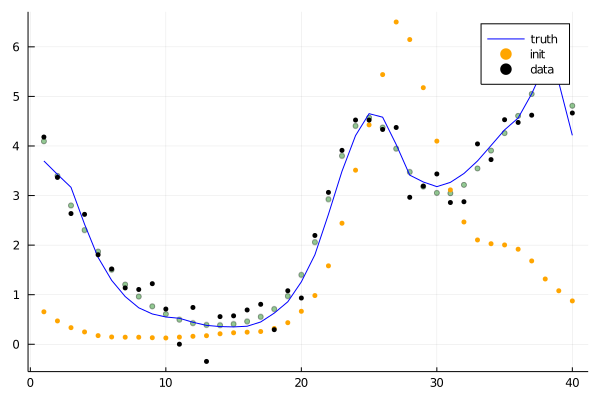

In [69]:
plt = scatter()
next_iteration = first_iteration
for i in 1:5
    display(hcat(next_iteration, true_params))
    next_iteration = mgvi_kl_optimize_step(model, data, next_iteration; jacobian_func=FwdDerJacobianFunc, residual_sampler=FullResidualSampler)
    plot_iteration_light(next_iteration, i)
end
display(hcat(next_iteration, true_params))

init_plots()
display(plt)

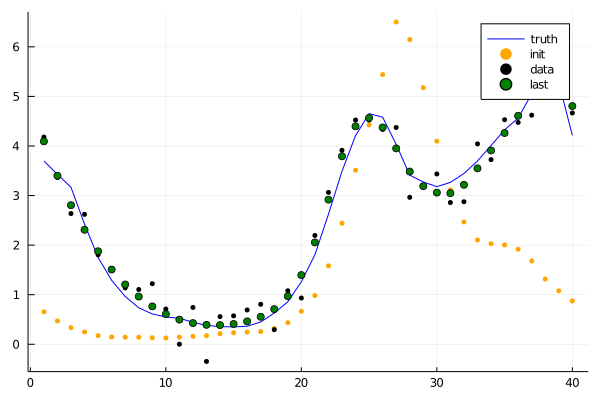

In [70]:
plot()
init_plots()
plot_iteration(next_iteration, "last")